# Adaptive hyperparameter optimization
This notebook shows off a model selection algorithm that is now a part of Dask-ML, Hyperband.

## Problem
Any machine learning model requires tuning many "hyper-parameters" for good performance, and is mentioned in the Scikit-Learn docs under "[Tuning the hyper-parameters of an estimator]".

This notebook will walk through a case of "image denoising". Getting good performance out of this model requires tuning these parameters:

``` python
params = {
    'module__init',
    'module__activation',
    'optimizer',
    'batch_size',
    'optimizer__lr',
    'optimizer__weight_decay',
}
```

These are incredibly important, and fairly basic. They answer the questions of

* How is the network initialization?
* How is the model optimized? What are some of the hyper-parameters for `optimizer`?

[Tuning the hyper-parameters of an estimator]:http://scikit-learn.org/stable/modules/grid_search.html


This notebook looks at a realistic use case of hyperparameter optimization. To do this, this notebook uses

* a realistic deep learning model
* a realistic set of hyperparameters

There are many hyperparameter for any model or framework. These can be specific to the model, or be related to the optimization framework used to minimize the model.

This notebook will show

* the model input and output (noisy and clean images respectively)
* the parameter space we are searching over
* a newly developed hyperparameter optimization algorithm and it's integration
* a comparison with 3 hyperparameter selection algorithms

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [2]:
# !export PYTHONPATH=../src:$PYTHONPATH
# !echo $PYTHONPATH
!cp -u ../src/noisy_mnist.py . 


In [3]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2024-02-01


In [4]:
import os
path = "/".join(os.getcwd().split("/")[:-1])
results_folder = f"data/results/skorch_run/{today}"
absolutepath_to_results = os.path.join(path,results_folder)
os.makedirs(absolutepath_to_results,exist_ok=True)


In [5]:
import socket
s=socket.socket()
s.bind(("", 0))
port = s.getsockname()[1]
s.close()

In [6]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

In [7]:
cluster = LocalCUDACluster(dashboard_address=f"127.0.0.1:{port}")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:53747/status,
Dashboard: http://127.0.0.1:53747/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39393,Workers: 2
Dashboard: http://127.0.0.1:53747/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:41215,Total threads: 1
Dashboard: http://127.0.0.1:44589/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:38073,


In [8]:
%time client.upload_file('../models/autoencoder.py')

CPU times: user 1.73 s, sys: 302 ms, total: 2.03 s
Wall time: 3.81 s


{'tcp://127.0.0.1:36517': {'status': 'OK'},
 'tcp://127.0.0.1:41215': {'status': 'OK'}}

In [9]:
import dask_ml
from dask_ml.model_selection import HyperbandSearchCV
import dask_ml
print (f'Dask ml version : {dask_ml.__version__}' ) 

Dask ml version : 2023.3.24


## Data
See below for an image.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [11]:
import noisy_mnist
chunk_size = 70_000 // 3
_X, _y = noisy_mnist.dataset()
_X = _X[:chunk_size * 3]
_y = _y[:chunk_size * 3]

In [12]:
_X.shape, _X.dtype, _X.min(), _X.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [13]:
_y.shape, _y.dtype, _y.min(), _y.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [14]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>,
 dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>)

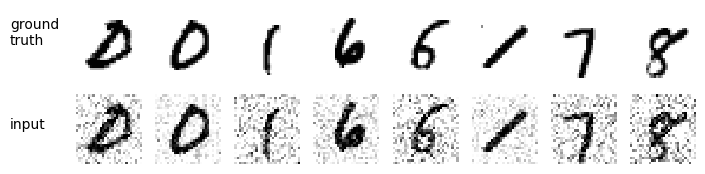

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

rng = check_random_state(42)
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = rng.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig(f"{absolutepath_to_results}/input-output.svg", bbox_inches="tight")
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [16]:
from autoencoder import Autoencoder, NegLossScore
import torch
# from sklearn.model_selection import ParameterSampler
# import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [17]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

I am testing `optimizer` to be `SGD` or `Adam` to test "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [18]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [19]:
import json
# import msgpack

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [20]:

import msgpack
# from sklearn.externals import joblib

def save_search(search, today, prefix, X, y):
    # create the folder into results and direct the results over there
    path = "/".join(os.getcwd().split("/")[:-1])
    results_folder = f"results/skorch_run/{today}"
    absolutepath_to_results = os.path.join(path,results_folder)
    os.makedirs(absolutepath_to_results,exist_ok=True)
    pre = f"{absolutepath_to_results}/{today}-{prefix}-"


    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        y_hat = y_hat.compute()
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k and "param_distribution" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

## Hyperparameter optimization

In [21]:
X

dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>

In [22]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(7002, 784), dtype=float32, chunksize=(2334, 784), chunktype=numpy.ndarray>)

In [23]:
y_train

dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>

In [24]:
from sklearn.linear_model import SGDClassifier

max_iter = 20 # originally this number was 250 to make a decent predeiction
history = {}
cv_results = {}
searches = {}

In [25]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperband

In [26]:
search = HyperbandSearchCV(model, params, max_iter, random_state=42)

In [27]:
y_train.shape

(62997, 784)

In [28]:
search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 1.9806122779846191
steps = 1, loss = 1.0360331535339355
steps = 1, loss = 2.1913440227508545
steps = 1, loss = 0.7192431688308716
steps = 1, loss = 2.127898693084717
steps = 1, loss = 2.6828114986419678
steps = 1, loss = 3.06661319732666
steps = 1, loss = 2.2211263179779053
steps = 6, loss = 2.970004081726074
steps = 6, loss = 2.6803536415100098
steps = 6, loss = 3.038644790649414
steps = 20, loss = 2.4946885108947754
steps = 6, loss = 2.069948196411133
steps = 20, loss = 2.8703525066375732
steps = 6, loss = 2.8672666549682617
steps = 20, loss = 1.9961414337158203
steps = 1, loss = 2.544604539871216
steps = 1, loss = 2.0932459831237793
steps = 1, loss = 1.9373981952667236
steps = 1, loss = 1.9419381618499756
steps = 1, loss = 1.968277096748352
steps = 1, loss = 2.0826468467712402
steps = 1, loss = 0.6949446797370911
steps = 1, loss = 2.059528350830078
steps = 1, loss = 2.4191715717315674
steps = 2, loss = 2.104903221130371
steps = 2, loss = 2.0371975898742676
steps = 

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=20,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'SG...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  random_state=42)

In [29]:
# timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [30]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): PReLU(num_parameters=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [31]:
search.best_score_

-1.8360058069229126

In [32]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.06006006006006006,
 'optimizer__lr': 0.03487727474814178,
 'optimizer': 'SGD',
 'module__init': 'xavier_uniform_',
 'module__activation': 'PReLU',
 'batch_size': 256}

In [33]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

### Hyperband + SOP

In [34]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=42, patience=True)

In [35]:
search_patience.fit(X_train, y_train, **fit_params)

steps = 1, loss = 2.0490026473999023
steps = 1, loss = 2.210167169570923
steps = 1, loss = 1.9728707075119019
steps = 1, loss = 1.1303688287734985
steps = 1, loss = 2.8418824672698975
steps = 1, loss = 0.7249541878700256
steps = 1, loss = 1.8006958961486816
steps = 1, loss = 3.1030313968658447
steps = 7, loss = 1.7099406719207764
steps = 7, loss = 2.5684664249420166
steps = 6, loss = 2.6784870624542236
steps = 7, loss = 1.9947890043258667
steps = 6, loss = 2.6379828453063965
steps = 6, loss = 2.9682457447052
steps = 6, loss = 2.9043045043945312
steps = 1, loss = 1.9684104919433594
steps = 1, loss = 2.4500741958618164
steps = 1, loss = 2.505847930908203
steps = 1, loss = 2.5856058597564697
steps = 6, loss = 3.1149489879608154
steps = 1, loss = 1.9604227542877197
steps = 1, loss = 2.1262154579162598
steps = 1, loss = 2.080721855163574
steps = 1, loss = 2.082385778427124
steps = 1, loss = 0.6951364874839783
steps = 2, loss = 2.58088755607605
steps = 2, loss = 2.107950210571289
steps = 2, 

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=20,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'SG...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  patience=True, random_state=42)

In [36]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

In [37]:
# timing_stats = timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband+sop-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [38]:
search_patience.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): PReLU(num_parameters=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [39]:
search_patience.best_score_

-0.8969807624816895

In [40]:
search_patience.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.06006006006006006,
 'optimizer__lr': 0.03487727474814178,
 'optimizer': 'SGD',
 'module__init': 'xavier_uniform_',
 'module__activation': 'PReLU',
 'batch_size': 256}

### Visualizing output of best estimator

In [41]:
noisy_test = X_test.compute()

In [42]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7002, 2, 784)

In [43]:
# i = rng.choice(len(X_test))
# print (i , type (clean_hat[i]) )
# clean_hat[i].size
# clean_hat[i].shape

In [44]:
# last_dimension = clean_hat[i][1]
# print (last_dimension.shape)
# last_dimension.reshape(28,28)

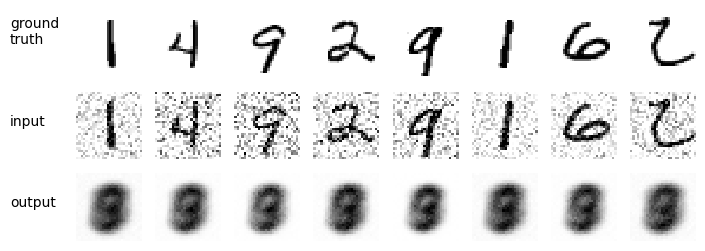

In [45]:
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
# plt.savefig("imgs/best-out.svg", bbox_inches="tight")
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [46]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

# n_workers = 32 or len(client.cluster.workers)
n_workers = len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, search.metadata_['partial_fit_calls']

(20, 7, 144)

In [47]:
from dask_ml.model_selection import IncrementalSearchCV

passive_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=42
)

In [48]:
passive_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 0.7754626870155334
steps = 1, loss = 2.2646145820617676
steps = 1, loss = 1.9933562278747559
steps = 1, loss = 0.7142400741577148
steps = 1, loss = 1.141473650932312
steps = 1, loss = 1.993848443031311
steps = 1, loss = 2.0440995693206787
steps = 2, loss = 1.2408353090286255
steps = 2, loss = 2.19974946975708
steps = 2, loss = 0.7748184204101562
steps = 2, loss = 2.152426242828369
steps = 2, loss = 1.6500004529953003
steps = 2, loss = 2.1665501594543457
steps = 2, loss = 2.4061098098754883
steps = 3, loss = 1.5540611743927002
steps = 3, loss = 2.4414358139038086
steps = 3, loss = 1.782746434211731
steps = 3, loss = 2.6199629306793213
steps = 3, loss = 1.0322555303573608
steps = 3, loss = 2.4358699321746826
steps = 3, loss = 2.397703170776367
steps = 4, loss = 1.3557788133621216
steps = 4, loss = 2.7230491638183594
steps = 4, loss = 2.5135157108306885
steps = 4, loss = 2.5897955894470215
steps = 4, loss = 2.718863010406494
steps = 4, loss = 1.8727045059204102
steps = 4

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=20, n_initial_parameters=7,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_normal...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    random_state=42)

In [49]:
save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

In [50]:
# timing_stats = client.profile()
# with open(f"{absolutepath_to_results}/final-final-timings.json", "w") as f:
#     json.dump(timing_stats, f)

2024-02-01 17:40:20,266 - distributed.sizeof - WARNING - Sizeof calculation failed. Defaulting to -1 B
Traceback (most recent call last):
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/sizeof.py", line 17, in safe_sizeof
    return sizeof(obj)
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask/utils.py", line 642, in __call__
    return meth(arg, *args, **kwargs)
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask/sizeof.py", line 96, in sizeof_python_dict
    + sizeof(list(d.values()))
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask/utils.py", line 642, in __call__
    return meth(arg, *args, **kwargs)
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask/sizeof.py", line 59, in sizeof_python_collection
    return sys.getsizeof(seq) + sum(map(sizeof, seq))
  File "/home/barradd/miniconda3/envs/rapids-23.12/l

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [51]:
from dask_ml.model_selection import IncrementalSearchCV

patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=42,
)

In [52]:
patience_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 1.9143904447555542
steps = 1, loss = 0.7757619023323059
steps = 1, loss = 0.7118386030197144
steps = 1, loss = 2.4552507400512695
steps = 1, loss = 2.539412260055542
steps = 1, loss = 1.9693399667739868
steps = 1, loss = 2.5098135471343994
steps = 1, loss = 2.0133111476898193
steps = 1, loss = 2.0113365650177
steps = 1, loss = 2.5529627799987793
steps = 1, loss = 0.7024389505386353
steps = 1, loss = 1.9313437938690186
steps = 1, loss = 1.9932304620742798
steps = 1, loss = 1.0914103984832764
steps = 2, loss = 1.2621498107910156
steps = 2, loss = 0.7598839402198792
steps = 2, loss = 2.6140377521514893
steps = 2, loss = 2.0718135833740234
steps = 2, loss = 2.5862491130828857
steps = 2, loss = 2.7528164386749268
steps = 2, loss = 2.1431782245635986
steps = 2, loss = 2.2473223209381104
steps = 2, loss = 2.403663396835327
steps = 2, loss = 1.372373342514038
steps = 2, loss = 2.163146495819092
steps = 2, loss = 2.8027005195617676
steps = 2, loss = 2.2365057468414307
steps = 

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=20, n_initial_parameters=14,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norma...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    patience=2, random_state=42)

In [53]:
patience_search.best_score_

-0.7598839402198792

In [54]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())

In [55]:
timing_stats = client.profile()
with open(f"{absolutepath_to_results}/final-timings.json", "w") as f:
    json.dump(timing_stats, f)

In [56]:
data, fig = client.get_task_stream(plot=True)

In [57]:
import pandas as pd
df = pd.DataFrame(list(data))

In [58]:
df.head()

,stimulus_id,worker,nbytes,type,typename,metadata,thread,startstops,status,key
0,task-finished-1706797778.4289412,tcp://127.0.0.1:36517,2151,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140253088179968,"({'action': 'transfer', 'start': 1706797772.34...",OK,_partial_fit-9aeba44f-26fc-4b95-ad5d-d0635c2dfe13
1,task-finished-1706797779.0293283,tcp://127.0.0.1:41215,2148,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139950477526784,"({'action': 'compute', 'start': 1706797776.097...",OK,_partial_fit-8b6607a6-26a8-4e84-82e3-3d43d51e6e10
2,task-finished-1706797781.3298726,tcp://127.0.0.1:41215,2146,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139950477526784,"({'action': 'compute', 'start': 1706797779.033...",OK,_partial_fit-ad1d83d7-da8b-43ac-bb6b-074372031807
3,task-finished-1706797784.2963371,tcp://127.0.0.1:41215,2148,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139950477526784,"({'action': 'compute', 'start': 1706797781.335...",OK,_partial_fit-fe758a0e-b466-49e6-a84f-ea27289fa3f9
4,task-finished-1706797784.524791,tcp://127.0.0.1:36517,2151,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140253088179968,"({'action': 'compute', 'start': 1706797778.442...",OK,_partial_fit-f7f15e95-d6c7-407c-b935-ceed4073355f
